## Importing the relevant libraries

In [279]:
import torch, time
import torch.nn as nn
import torch.nn.functional as F
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid
from torchvision import datasets, transforms, models
from torchinfo import summary

In [117]:
if torch.cuda.is_available():
    device = torch.cuda.current_device()
    print("Device:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name())

Device: 0
Device name: Tesla T4


## Loading the image dataset

In [3]:
img_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=30),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.GaussianBlur(kernel_size=(5,9),sigma=(0.1,4)),
    transforms.RandomAdjustSharpness(sharpness_factor=4,p=0.5),
    transforms.Resize((128,128)),
    transforms.CenterCrop((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])

In [4]:
dataset = datasets.ImageFolder(root="/kaggle/input/grapevine-leaves-image-dataset/Grapevine_Leaves_Image_Dataset",transform=img_transforms)
dataset

Dataset ImageFolder
    Number of datapoints: 500
    Root location: /kaggle/input/grapevine-leaves-image-dataset/Grapevine_Leaves_Image_Dataset
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.4)
               RandomVerticalFlip(p=0.3)
               GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 4))
               RandomAdjustSharpness(sharpness_factor=4,p=0.5)
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(128, 128))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

## Performing train test split

In [7]:
lengths = (int(len(dataset)*0.8),len(dataset)-int(len(dataset)*0.8))
lengths

(400, 100)

In [9]:
train_set, test_set = random_split(dataset=dataset,lengths=lengths)

## Creating train and test data loaders

In [10]:
train_data_loader = DataLoader(dataset=train_set,batch_size=32,pin_memory=True,shuffle=True,pin_memory_device="cuda")
test_data_loader = DataLoader(dataset=test_set,batch_size=32,shuffle=True,pin_memory=True,pin_memory_device="cuda")

## Assessing distribution of grapevine leaves

In [280]:
all_labels = []

for _, labels in train_data_loader:
    all_labels.extend(labels.tolist())

for _, labels in test_data_loader:
    all_labels.extend(labels.tolist())
    
set(all_labels)

{0, 1, 2, 3, 4}

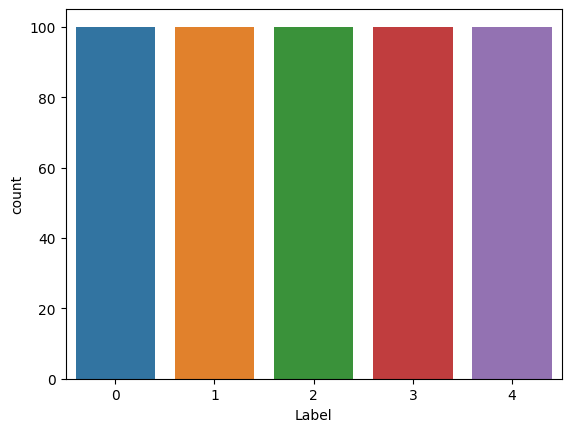

In [283]:
labels_df = pd.DataFrame(all_labels,columns=['Label'])
sns.countplot(data=labels_df,x='Label');

There is an equal distribution of all grapevine leaves.

In [284]:
del labels_df

In [14]:
dataset.class_to_idx

{'Ak': 0, 'Ala_Idris': 1, 'Buzgulu': 2, 'Dimnit': 3, 'Nazli': 4}

In [15]:
len(train_data_loader)

13

In [19]:
len(train_data_loader.dataset)

400

## Visualizing a sample batch of leave images in train data loader

In [11]:
for images, labels in train_data_loader:
    break

In [12]:
images.shape

torch.Size([32, 3, 128, 128])

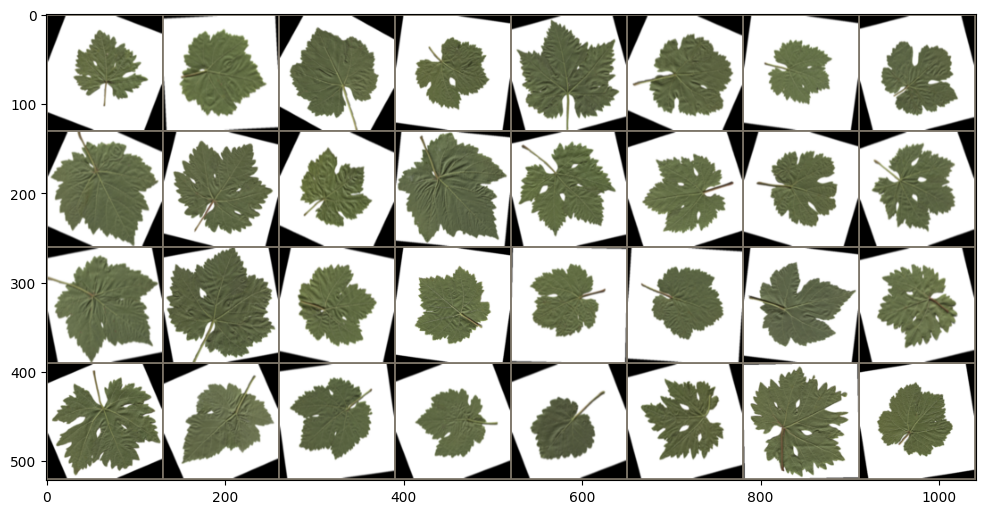

In [17]:
batch_images = make_grid(tensor=images,nrow=8)
inv_normalize = transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],std=[1/0.229,1/0.224,1/0.225])
inv_normalized_images = inv_normalize(batch_images)

plt.figure(figsize=(12,8))
plt.imshow(np.transpose(inv_normalized_images.numpy(),(1,2,0)));

## Defining the CNN model architecture

In [29]:
class CNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=128,kernel_size=(3,3),stride=1) # 63,63,128
        self.conv2 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=(3,3),stride=1) # 30,30,256
        self.conv3 = nn.Conv2d(in_channels=256,out_channels=512,kernel_size=(3,3),stride=1) # 14,14,512
        self.fc1 = nn.Linear(in_features=14*14*512,out_features=512)
        self.fc2 = nn.Linear(in_features=512,out_features=256)
        self.fc3 = nn.Linear(in_features=256,out_features=128)
        self.fc4 = nn.Linear(in_features=128,out_features=5)

    def forward(self,X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,kernel_size=(2,2),stride=2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,kernel_size=(2,2),stride=2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X,kernel_size=(2,2),stride=2)
        X = X.view(-1,14*14*512)
        X = F.relu(self.fc1(X))
        X = F.dropout(X,0.4)
        X = F.relu(self.fc2(X))
        X = F.dropout(X,0.3)
        X = F.relu(self.fc3(X))
        X = F.dropout(X,0.2)
        X = self.fc4(X)
        return F.log_softmax(X,dim=1)

In [30]:
torch.manual_seed(28)
model = CNN().cuda()
model

CNN(
  (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=5, bias=True)
)

In [31]:
summary(model=model,input_size=(1,3,128,128))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 5]                    --
├─Conv2d: 1-1                            [1, 128, 126, 126]        3,584
├─Conv2d: 1-2                            [1, 256, 61, 61]          295,168
├─Conv2d: 1-3                            [1, 512, 28, 28]          1,180,160
├─Linear: 1-4                            [1, 512]                  51,380,736
├─Linear: 1-5                            [1, 256]                  131,328
├─Linear: 1-6                            [1, 128]                  32,896
├─Linear: 1-7                            [1, 5]                    645
Total params: 53,024,517
Trainable params: 53,024,517
Non-trainable params: 0
Total mult-adds (G): 2.13
Input size (MB): 0.20
Forward/backward pass size (MB): 27.10
Params size (MB): 212.10
Estimated Total Size (MB): 239.39

In [32]:
total_params = 0

for param in model.parameters():
    print(param.numel())
    total_params += param.numel()

print("Total CNN parameters:", total_params)

3456
128
294912
256
1179648
512
51380224
512
131072
256
32768
128
640
5
Total CNN parameters: 53024517


In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),lr=0.001)

## Training and evaluating the CNN model

In [35]:
epochs = 100

train_losses = []
test_losses = []
train_correct_predictions = []
test_correct_predictions = []

start_time = time.time()

for i in range(1,epochs):
    train_correct = 0
    test_correct = 0

    for batch_no, (X_train, y_train) in enumerate(train_data_loader):
        batch_no += 1
        X_train, y_train = X_train.cuda(), y_train.cuda()
        y_pred = model(X_train)  
        loss = criterion(y_pred,y_train)
        predicted = torch.max(y_pred,1)[1]
        train_correct += (predicted == y_train).sum()

        optimizer.zero_grad() # Reset model gradients to zero
        loss.backward() # Perform backpropagation
        optimizer.step() # Updates model weights and biases

        print(f"Epoch: {i} Batch: {batch_no} --> Loss: {loss.item()}")

    train_losses.append(loss.item())
    train_correct_predictions.append(train_correct.item())

    with torch.no_grad():
        for batch_no, (X_test, y_test) in enumerate(test_data_loader):
            X_test, y_test = X_test.cuda(), y_test.cuda()
            y_pred = model(X_test)
            predicted = torch.max(y_pred,1)[1]
            test_correct += (predicted == y_test).sum()

    loss = criterion(y_pred,y_test)
    test_losses.append(loss.item())
    test_correct_predictions.append(test_correct.item())

print(f"Total time elapsed in CNN model training: {(time.time()-start_time)/60} minutes")

Epoch: 1 Batch: 1 --> Loss: 1.616325855255127
Epoch: 1 Batch: 2 --> Loss: 2.2033963203430176
Epoch: 1 Batch: 3 --> Loss: 1.7544121742248535
Epoch: 1 Batch: 4 --> Loss: 1.603977918624878
Epoch: 1 Batch: 5 --> Loss: 1.5829198360443115
Epoch: 1 Batch: 6 --> Loss: 1.6924539804458618
Epoch: 1 Batch: 7 --> Loss: 1.625676155090332
Epoch: 1 Batch: 8 --> Loss: 1.6065948009490967
Epoch: 1 Batch: 9 --> Loss: 1.6157671213150024
Epoch: 1 Batch: 10 --> Loss: 1.6138317584991455
Epoch: 1 Batch: 11 --> Loss: 1.6212003231048584
Epoch: 1 Batch: 12 --> Loss: 1.6121623516082764
Epoch: 1 Batch: 13 --> Loss: 1.5873758792877197
Epoch: 2 Batch: 1 --> Loss: 1.6025264263153076
Epoch: 2 Batch: 2 --> Loss: 1.59964919090271
Epoch: 2 Batch: 3 --> Loss: 1.616410732269287
Epoch: 2 Batch: 4 --> Loss: 1.5995826721191406
Epoch: 2 Batch: 5 --> Loss: 1.6369695663452148
Epoch: 2 Batch: 6 --> Loss: 1.5930222272872925
Epoch: 2 Batch: 7 --> Loss: 1.6132276058197021
Epoch: 2 Batch: 8 --> Loss: 1.617110252380371
Epoch: 2 Batch: 

## Visualizing model performance

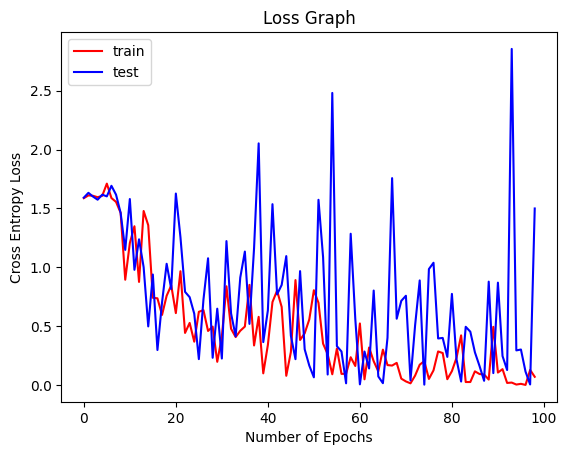

In [36]:
plt.plot(train_losses,'r',label='train')
plt.plot(test_losses,'b',label='test')
plt.xlabel('Number of Epochs')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.legend()
plt.show();

In [38]:
train_accuracies = [x/len(train_set) for x in train_correct_predictions]
test_accuracies = [x/len(test_set) for x in test_correct_predictions]

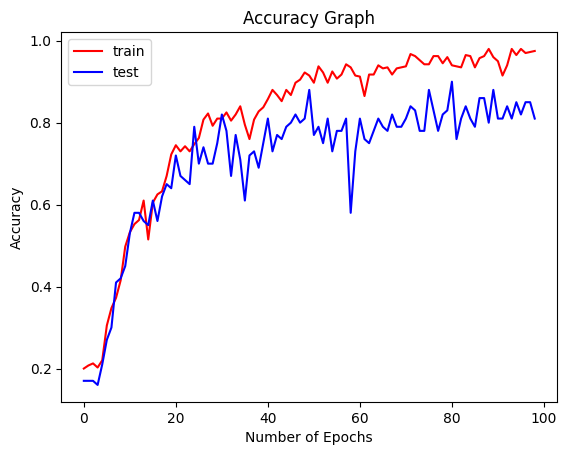

In [39]:
plt.plot(train_accuracies,'r',label='train')
plt.plot(test_accuracies,'b',label='test')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show();

## Saving the baseline CNN model

In [40]:
torch.save(model,'grapevine_leaves_image_classifier.pt')

## Fine-tuning pretrained image classification models

### AlexNet

In [41]:
alexnet = models.alexnet(pretrained=True)
alexnet = alexnet.cuda()
alexnet

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 108MB/s]  


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [43]:
total_params = 0

for param in alexnet.parameters():
    param.requires_grad = False
    print(param.numel())
    total_params += param.numel()

print("Total Alexnet parameters:", total_params)

23232
64
307200
192
663552
384
884736
256
589824
256
37748736
4096
16777216
4096
4096000
1000
Total Alexnet parameters: 61100840


In [44]:
alexnet.classifier = nn.Sequential(
    nn.Linear(9216,1024),
    nn.ReLU(inplace=True),
    nn.Linear(1024,512),
    nn.ReLU(inplace=True),
    nn.Linear(512,5),
    nn.LogSoftmax(dim=1)
)
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Lin

In [46]:
summary(alexnet,input_size=(1,3,128,128))

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [1, 5]                    --
├─Sequential: 1-1                        [1, 256, 3, 3]            --
│    └─Conv2d: 2-1                       [1, 64, 31, 31]           (23,296)
│    └─ReLU: 2-2                         [1, 64, 31, 31]           --
│    └─MaxPool2d: 2-3                    [1, 64, 15, 15]           --
│    └─Conv2d: 2-4                       [1, 192, 15, 15]          (307,392)
│    └─ReLU: 2-5                         [1, 192, 15, 15]          --
│    └─MaxPool2d: 2-6                    [1, 192, 7, 7]            --
│    └─Conv2d: 2-7                       [1, 384, 7, 7]            (663,936)
│    └─ReLU: 2-8                         [1, 384, 7, 7]            --
│    └─Conv2d: 2-9                       [1, 256, 7, 7]            (884,992)
│    └─ReLU: 2-10                        [1, 256, 7, 7]            --
│    └─Conv2d: 2-11                      [1, 256, 7, 7]   

In [47]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=alexnet.parameters(),lr=0.001)

In [48]:
epochs = 10

train_losses = []
test_losses = []
train_correct_predictions = []
test_correct_predictions = []

start_time = time.time()

for i in range(1,epochs):
    train_correct = 0
    test_correct = 0

    for batch_no, (X_train, y_train) in enumerate(train_data_loader):
        batch_no += 1
        X_train, y_train = X_train.cuda(), y_train.cuda()
        y_pred = alexnet(X_train)  
        loss = criterion(y_pred,y_train)
        predicted = torch.max(y_pred,1)[1]
        train_correct += (predicted == y_train).sum()

        optimizer.zero_grad() # Reset model gradients to zero
        loss.backward() # Perform backpropagation
        optimizer.step() # Updates model weights and biases

        print(f"Epoch: {i} Batch: {batch_no} --> Loss: {loss.item()}")

    train_losses.append(loss.item())
    train_correct_predictions.append(train_correct.item())

    with torch.no_grad():
        for batch_no, (X_test, y_test) in enumerate(test_data_loader):
            X_test, y_test = X_test.cuda(), y_test.cuda()
            y_pred = alexnet(X_test)
            predicted = torch.max(y_pred,1)[1]
            test_correct += (predicted == y_test).sum()

    loss = criterion(y_pred,y_test)
    test_losses.append(loss.item())
    test_correct_predictions.append(test_correct.item())

print(f"Total time elapsed in Alexnet model training: {(time.time()-start_time)/60} minutes")

Epoch: 1 Batch: 1 --> Loss: 1.6011909246444702
Epoch: 1 Batch: 2 --> Loss: 3.721874713897705
Epoch: 1 Batch: 3 --> Loss: 3.1572279930114746
Epoch: 1 Batch: 4 --> Loss: 4.88553524017334
Epoch: 1 Batch: 5 --> Loss: 5.018734455108643
Epoch: 1 Batch: 6 --> Loss: 3.974104881286621
Epoch: 1 Batch: 7 --> Loss: 2.387923240661621
Epoch: 1 Batch: 8 --> Loss: 1.7733145952224731
Epoch: 1 Batch: 9 --> Loss: 1.6076273918151855
Epoch: 1 Batch: 10 --> Loss: 1.6979365348815918
Epoch: 1 Batch: 11 --> Loss: 1.6435680389404297
Epoch: 1 Batch: 12 --> Loss: 2.0408501625061035
Epoch: 1 Batch: 13 --> Loss: 1.9750587940216064
Epoch: 2 Batch: 1 --> Loss: 1.6131870746612549
Epoch: 2 Batch: 2 --> Loss: 1.5918048620224
Epoch: 2 Batch: 3 --> Loss: 1.4881584644317627
Epoch: 2 Batch: 4 --> Loss: 1.7055011987686157
Epoch: 2 Batch: 5 --> Loss: 1.5461535453796387
Epoch: 2 Batch: 6 --> Loss: 1.3860560655593872
Epoch: 2 Batch: 7 --> Loss: 1.4390196800231934
Epoch: 2 Batch: 8 --> Loss: 1.5046453475952148
Epoch: 2 Batch: 9 

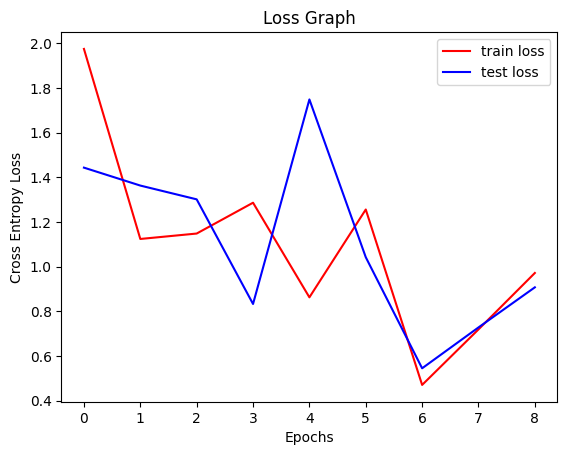

In [50]:
plt.plot(train_losses,'r',label='train loss')
plt.plot(test_losses,'b',label='test loss')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.legend()
plt.show();

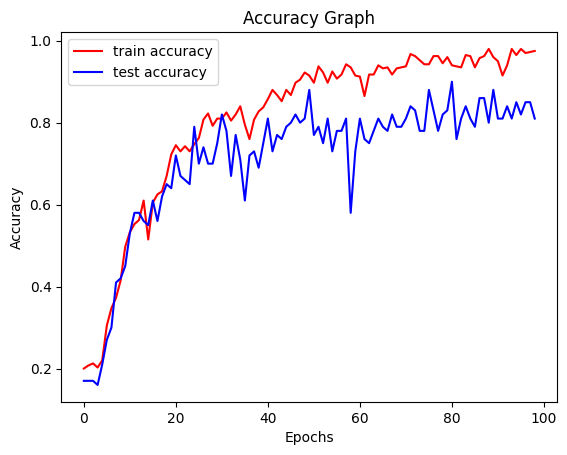

In [51]:
plt.plot(train_accuracies,'r',label='train accuracy')
plt.plot(test_accuracies,'b',label='test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show();

In [52]:
torch.save(alexnet,'grapevine_leaves_image_alexnet_classifier.pt')

### ResNet50

In [53]:
resnet = models.resnet50(pretrained=True)
resnet = resnet.cuda()
resnet

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 97.0MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [55]:
total_params = 0

for param in resnet.parameters():
    param.requires_grad = False
    print(param.numel())
    total_params += param.numel()

print("Total Resnet50 parameters:", total_params)

9408
64
64
4096
64
64
36864
64
64
16384
256
256
16384
256
256
16384
64
64
36864
64
64
16384
256
256
16384
64
64
36864
64
64
16384
256
256
32768
128
128
147456
128
128
65536
512
512
131072
512
512
65536
128
128
147456
128
128
65536
512
512
65536
128
128
147456
128
128
65536
512
512
65536
128
128
147456
128
128
65536
512
512
131072
256
256
589824
256
256
262144
1024
1024
524288
1024
1024
262144
256
256
589824
256
256
262144
1024
1024
262144
256
256
589824
256
256
262144
1024
1024
262144
256
256
589824
256
256
262144
1024
1024
262144
256
256
589824
256
256
262144
1024
1024
262144
256
256
589824
256
256
262144
1024
1024
524288
512
512
2359296
512
512
1048576
2048
2048
2097152
2048
2048
1048576
512
512
2359296
512
512
1048576
2048
2048
1048576
512
512
2359296
512
512
1048576
2048
2048
2048000
1000
Total Resnet50 parameters: 25557032


In [59]:
resnet.fc = nn.Sequential(
    nn.Linear(2048,1024),
    nn.ReLU(inplace=True),
    nn.Linear(1024,5),
    nn.LogSoftmax(dim=1)
)
resnet = resnet.cuda()
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [90]:
summary(resnet,input_size=(1,3,128,128))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 5]                    --
├─Conv2d: 1-1                            [1, 64, 64, 64]           (9,408)
├─BatchNorm2d: 1-2                       [1, 64, 64, 64]           (128)
├─ReLU: 1-3                              [1, 64, 64, 64]           --
├─MaxPool2d: 1-4                         [1, 64, 32, 32]           --
├─Sequential: 1-5                        [1, 256, 32, 32]          --
│    └─Bottleneck: 2-1                   [1, 256, 32, 32]          --
│    │    └─Conv2d: 3-1                  [1, 64, 32, 32]           (4,096)
│    │    └─BatchNorm2d: 3-2             [1, 64, 32, 32]           (128)
│    │    └─ReLU: 3-3                    [1, 64, 32, 32]           --
│    │    └─Conv2d: 3-4                  [1, 64, 32, 32]           (36,864)
│    │    └─BatchNorm2d: 3-5             [1, 64, 32, 32]           (128)
│    │    └─ReLU: 3-6                    [1, 64, 32, 32]    

In [60]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=resnet.parameters(),lr=0.001)

In [61]:
epochs = 10

train_losses = []
test_losses = []
train_correct_predictions = []
test_correct_predictions = []

start_time = time.time()

for i in range(1,epochs):
    train_correct = 0
    test_correct = 0

    for batch_no, (X_train, y_train) in enumerate(train_data_loader):
        batch_no += 1
        X_train, y_train = X_train.cuda(), y_train.cuda()
        y_pred = resnet(X_train)  
        loss = criterion(y_pred,y_train)
        predicted = torch.max(y_pred,1)[1]
        train_correct += (predicted == y_train).sum()

        optimizer.zero_grad() # Reset model gradients to zero
        loss.backward() # Perform backpropagation
        optimizer.step() # Updates model weights and biases

        print(f"Epoch: {i} Batch: {batch_no} --> Loss: {loss.item()}")

    train_losses.append(loss.item())
    train_correct_predictions.append(train_correct.item())

    with torch.no_grad():
        for batch_no, (X_test, y_test) in enumerate(test_data_loader):
            X_test, y_test = X_test.cuda(), y_test.cuda()
            y_pred = resnet(X_test)
            predicted = torch.max(y_pred,1)[1]
            test_correct += (predicted == y_test).sum()

    loss = criterion(y_pred,y_test)
    test_losses.append(loss.item())
    test_correct_predictions.append(test_correct.item())

print(f"Total time elapsed in Resnet50 model training: {(time.time()-start_time)/60} minutes")

Epoch: 1 Batch: 1 --> Loss: 1.5939335823059082
Epoch: 1 Batch: 2 --> Loss: 2.7298834323883057
Epoch: 1 Batch: 3 --> Loss: 1.7618833780288696
Epoch: 1 Batch: 4 --> Loss: 1.6983354091644287
Epoch: 1 Batch: 5 --> Loss: 2.4312098026275635
Epoch: 1 Batch: 6 --> Loss: 1.9490422010421753
Epoch: 1 Batch: 7 --> Loss: 1.5072420835494995
Epoch: 1 Batch: 8 --> Loss: 1.6258118152618408
Epoch: 1 Batch: 9 --> Loss: 1.4239641427993774
Epoch: 1 Batch: 10 --> Loss: 1.392236351966858
Epoch: 1 Batch: 11 --> Loss: 1.5018755197525024
Epoch: 1 Batch: 12 --> Loss: 1.4516232013702393
Epoch: 1 Batch: 13 --> Loss: 1.3646228313446045
Epoch: 2 Batch: 1 --> Loss: 1.233972430229187
Epoch: 2 Batch: 2 --> Loss: 1.1584628820419312
Epoch: 2 Batch: 3 --> Loss: 1.42399263381958
Epoch: 2 Batch: 4 --> Loss: 1.3545286655426025
Epoch: 2 Batch: 5 --> Loss: 1.2329972982406616
Epoch: 2 Batch: 6 --> Loss: 1.129860758781433
Epoch: 2 Batch: 7 --> Loss: 1.301087737083435
Epoch: 2 Batch: 8 --> Loss: 0.9507721066474915
Epoch: 2 Batch:

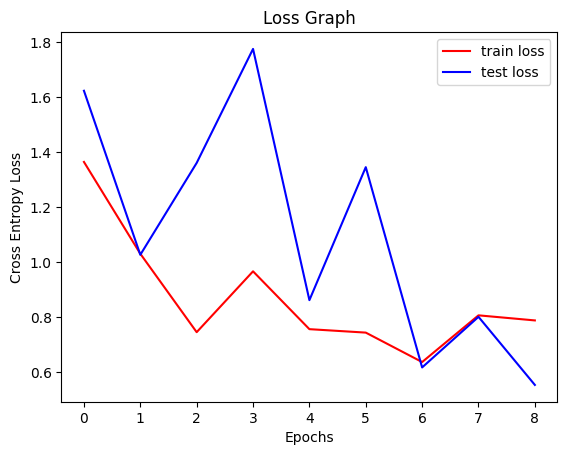

In [62]:
plt.plot(train_losses,'r',label='train loss')
plt.plot(test_losses,'b',label='test loss')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.legend()
plt.show();

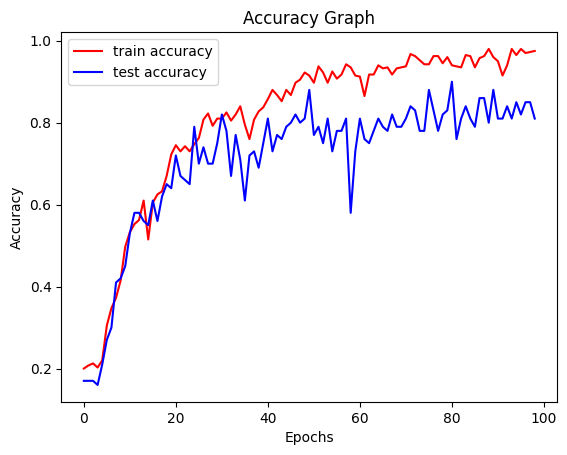

In [63]:
plt.plot(train_accuracies,'r',label='train accuracy')
plt.plot(test_accuracies,'b',label='test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show();

In [64]:
torch.save(resnet,'grapevine_leaves_image_resnet_classifier.pt')

### VGG19

In [65]:
vgg19 = models.vgg19(pretrained=True)
vgg19

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 207MB/s]  


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [66]:
total_params = 0

for param in vgg19.parameters():
    param.requires_grad = False
    print(param.numel())
    total_params += param.numel()

print("Total VGG19 model parameters:", total_params)

1728
64
36864
64
73728
128
147456
128
294912
256
589824
256
589824
256
589824
256
1179648
512
2359296
512
2359296
512
2359296
512
2359296
512
2359296
512
2359296
512
2359296
512
102760448
4096
16777216
4096
4096000
1000
Total VGG19 model parameters: 143667240


In [70]:
vgg19.classifier = nn.Sequential(
    nn.Linear(25088,1024),
    nn.ReLU(inplace=True), 
    nn.Linear(1024,512),
    nn.ReLU(inplace=True),
    nn.Linear(512,5),
    nn.LogSoftmax(dim=1)
)
vgg19 = vgg19.cuda()
vgg19

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [89]:
summary(vgg19,input_size=(1,3,128,128))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 5]                    --
├─Sequential: 1-1                        [1, 512, 4, 4]            --
│    └─Conv2d: 2-1                       [1, 64, 128, 128]         (1,792)
│    └─ReLU: 2-2                         [1, 64, 128, 128]         --
│    └─Conv2d: 2-3                       [1, 64, 128, 128]         (36,928)
│    └─ReLU: 2-4                         [1, 64, 128, 128]         --
│    └─MaxPool2d: 2-5                    [1, 64, 64, 64]           --
│    └─Conv2d: 2-6                       [1, 128, 64, 64]          (73,856)
│    └─ReLU: 2-7                         [1, 128, 64, 64]          --
│    └─Conv2d: 2-8                       [1, 128, 64, 64]          (147,584)
│    └─ReLU: 2-9                         [1, 128, 64, 64]          --
│    └─MaxPool2d: 2-10                   [1, 128, 32, 32]          --
│    └─Conv2d: 2-11                      [1, 256, 32, 32]    

In [71]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(params=vgg19.parameters(),lr=0.001
                             )

In [72]:
epochs = 10

train_losses = []
test_losses = []
train_correct_predictions = []
test_correct_predictions = []

start_time = time.time()

for i in range(1,epochs):
    train_correct = 0
    test_correct = 0

    for batch_no, (X_train, y_train) in enumerate(train_data_loader):
        batch_no += 1
        X_train, y_train = X_train.cuda(), y_train.cuda()
        y_pred = vgg19(X_train)  
        loss = criterion(y_pred,y_train)
        predicted = torch.max(y_pred,1)[1]
        train_correct += (predicted == y_train).sum()

        optimizer.zero_grad() # Reset model gradients to zero
        loss.backward() # Perform backpropagation
        optimizer.step() # Updates model weights and biases

        print(f"Epoch: {i} Batch: {batch_no} --> Loss: {loss.item()}")

    train_losses.append(loss.item())
    train_correct_predictions.append(train_correct.item())

    with torch.no_grad():
        for batch_no, (X_test, y_test) in enumerate(test_data_loader):
            X_test, y_test = X_test.cuda(), y_test.cuda()
            y_pred = vgg19(X_test)
            predicted = torch.max(y_pred,1)[1]
            test_correct += (predicted == y_test).sum()

    loss = criterion(y_pred,y_test)
    test_losses.append(loss.item())
    test_correct_predictions.append(test_correct.item())

print(f"Total time elapsed in VGG19 model training: {(time.time()-start_time)/60} minutes")

Epoch: 1 Batch: 1 --> Loss: 1.6285420656204224
Epoch: 1 Batch: 2 --> Loss: 7.300101280212402
Epoch: 1 Batch: 3 --> Loss: 6.14141845703125
Epoch: 1 Batch: 4 --> Loss: 2.4060332775115967
Epoch: 1 Batch: 5 --> Loss: 2.1780896186828613
Epoch: 1 Batch: 6 --> Loss: 1.8546698093414307
Epoch: 1 Batch: 7 --> Loss: 1.7444437742233276
Epoch: 1 Batch: 8 --> Loss: 1.8351163864135742
Epoch: 1 Batch: 9 --> Loss: 2.0274784564971924
Epoch: 1 Batch: 10 --> Loss: 1.6020933389663696
Epoch: 1 Batch: 11 --> Loss: 1.8357807397842407
Epoch: 1 Batch: 12 --> Loss: 1.4620980024337769
Epoch: 1 Batch: 13 --> Loss: 1.6190704107284546
Epoch: 2 Batch: 1 --> Loss: 1.6318354606628418
Epoch: 2 Batch: 2 --> Loss: 1.4752740859985352
Epoch: 2 Batch: 3 --> Loss: 1.6276047229766846
Epoch: 2 Batch: 4 --> Loss: 1.561653971672058
Epoch: 2 Batch: 5 --> Loss: 1.3397220373153687
Epoch: 2 Batch: 6 --> Loss: 1.2116954326629639
Epoch: 2 Batch: 7 --> Loss: 1.5200121402740479
Epoch: 2 Batch: 8 --> Loss: 1.736147403717041
Epoch: 2 Batch

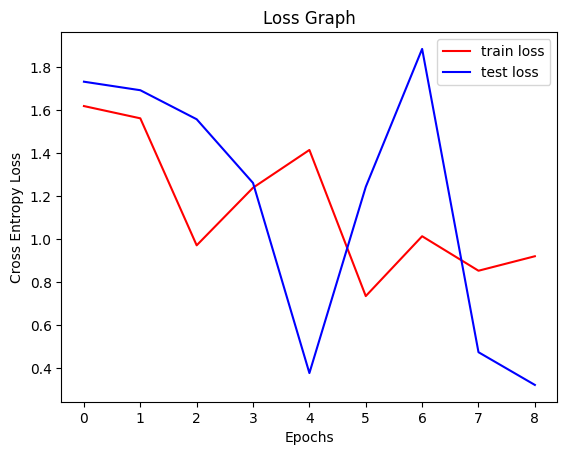

In [73]:
plt.plot(train_losses,'r',label='train loss')
plt.plot(test_losses,'b',label='test loss')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.legend()
plt.show();

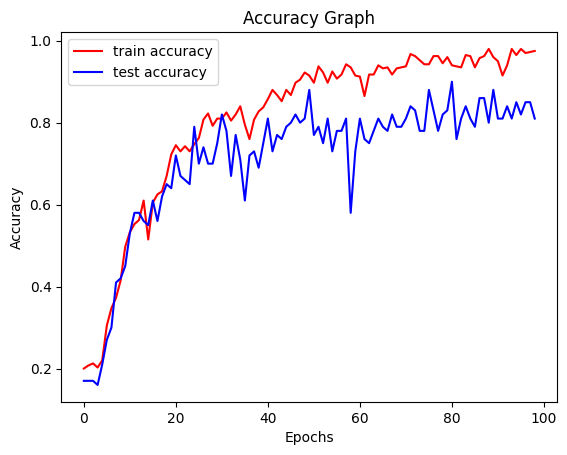

In [74]:
plt.plot(train_accuracies,'r',label='train accuracy')
plt.plot(test_accuracies,'b',label='test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show();

In [75]:
torch.save(vgg19,'grapevine_leaves_image_vgg19_classifier.pt')

### DenseNet 169

In [76]:
densenet = models.densenet169(pretrained=True)
densenet

Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth
100%|██████████| 54.7M/54.7M [00:00<00:00, 136MB/s] 


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [77]:
total_params = 0

for param in densenet.parameters():
    param.requires_grad = False
    print(param.numel())
    total_params += param.numel()

print("Total Densenet169 model parameters:", total_params)
    

9408
64
64
64
64
8192
128
128
36864
96
96
12288
128
128
36864
128
128
16384
128
128
36864
160
160
20480
128
128
36864
192
192
24576
128
128
36864
224
224
28672
128
128
36864
256
256
32768
128
128
16384
128
128
36864
160
160
20480
128
128
36864
192
192
24576
128
128
36864
224
224
28672
128
128
36864
256
256
32768
128
128
36864
288
288
36864
128
128
36864
320
320
40960
128
128
36864
352
352
45056
128
128
36864
384
384
49152
128
128
36864
416
416
53248
128
128
36864
448
448
57344
128
128
36864
480
480
61440
128
128
36864
512
512
131072
256
256
32768
128
128
36864
288
288
36864
128
128
36864
320
320
40960
128
128
36864
352
352
45056
128
128
36864
384
384
49152
128
128
36864
416
416
53248
128
128
36864
448
448
57344
128
128
36864
480
480
61440
128
128
36864
512
512
65536
128
128
36864
544
544
69632
128
128
36864
576
576
73728
128
128
36864
608
608
77824
128
128
36864
640
640
81920
128
128
36864
672
672
86016
128
128
36864
704
704
90112
128
128
36864
736
736
94208
128
128
36864
768
768
98304

In [81]:
densenet.classifier = nn.Sequential(
    nn.Linear(1664,1024),
    nn.ReLU(inplace=True),
    nn.Linear(1024,5),
    nn.LogSoftmax(dim=1)
)
densenet = densenet.cuda()
densenet

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [87]:
summary(densenet,input_size=(1,3,128,128))

Layer (type:depth-idx)                   Output Shape              Param #
DenseNet                                 [1, 5]                    --
├─Sequential: 1-1                        [1, 1664, 4, 4]           --
│    └─Conv2d: 2-1                       [1, 64, 64, 64]           (9,408)
│    └─BatchNorm2d: 2-2                  [1, 64, 64, 64]           (128)
│    └─ReLU: 2-3                         [1, 64, 64, 64]           --
│    └─MaxPool2d: 2-4                    [1, 64, 32, 32]           --
│    └─_DenseBlock: 2-5                  [1, 256, 32, 32]          --
│    │    └─_DenseLayer: 3-1             [1, 32, 32, 32]           (45,440)
│    │    └─_DenseLayer: 3-2             [1, 32, 32, 32]           (49,600)
│    │    └─_DenseLayer: 3-3             [1, 32, 32, 32]           (53,760)
│    │    └─_DenseLayer: 3-4             [1, 32, 32, 32]           (57,920)
│    │    └─_DenseLayer: 3-5             [1, 32, 32, 32]           (62,080)
│    │    └─_DenseLayer: 3-6             [1, 32

In [82]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=densenet.parameters(),lr=0.001)

In [83]:
epochs = 10

train_losses = []
test_losses = []
train_correct_predictions = []
test_correct_predictions = []

start_time = time.time()

for i in range(1,epochs):
    train_correct = 0
    test_correct = 0

    for batch_no, (X_train, y_train) in enumerate(train_data_loader):
        batch_no += 1
        X_train, y_train = X_train.cuda(), y_train.cuda()
        y_pred = densenet(X_train)  
        loss = criterion(y_pred,y_train)
        predicted = torch.max(y_pred,1)[1]
        train_correct += (predicted == y_train).sum()

        optimizer.zero_grad() # Reset model gradients to zero
        loss.backward() # Perform backpropagation
        optimizer.step() # Updates model weights and biases

        print(f"Epoch: {i} Batch: {batch_no} --> Loss: {loss.item()}")

    train_losses.append(loss.item())
    train_correct_predictions.append(train_correct.item())

    with torch.no_grad():
        for batch_no, (X_test, y_test) in enumerate(test_data_loader):
            X_test, y_test = X_test.cuda(), y_test.cuda()
            y_pred = densenet(X_test)
            predicted = torch.max(y_pred,1)[1]
            test_correct += (predicted == y_test).sum()

    loss = criterion(y_pred,y_test)
    test_losses.append(loss.item())
    test_correct_predictions.append(test_correct.item())

print(f"Total time elapsed in Densenet169 model training: {(time.time()-start_time)/60} minutes")

Epoch: 1 Batch: 1 --> Loss: 1.6552062034606934
Epoch: 1 Batch: 2 --> Loss: 2.0866448879241943
Epoch: 1 Batch: 3 --> Loss: 1.5564038753509521
Epoch: 1 Batch: 4 --> Loss: 1.5649274587631226
Epoch: 1 Batch: 5 --> Loss: 1.4653675556182861
Epoch: 1 Batch: 6 --> Loss: 1.5367611646652222
Epoch: 1 Batch: 7 --> Loss: 1.415984869003296
Epoch: 1 Batch: 8 --> Loss: 1.6232212781906128
Epoch: 1 Batch: 9 --> Loss: 1.2472463846206665
Epoch: 1 Batch: 10 --> Loss: 1.3976640701293945
Epoch: 1 Batch: 11 --> Loss: 1.427100419998169
Epoch: 1 Batch: 12 --> Loss: 1.36159348487854
Epoch: 1 Batch: 13 --> Loss: 1.317093849182129
Epoch: 2 Batch: 1 --> Loss: 1.4205079078674316
Epoch: 2 Batch: 2 --> Loss: 1.0789992809295654
Epoch: 2 Batch: 3 --> Loss: 1.2437111139297485
Epoch: 2 Batch: 4 --> Loss: 1.2955516576766968
Epoch: 2 Batch: 5 --> Loss: 1.4830724000930786
Epoch: 2 Batch: 6 --> Loss: 1.119692087173462
Epoch: 2 Batch: 7 --> Loss: 0.9405759572982788
Epoch: 2 Batch: 8 --> Loss: 0.9887852072715759
Epoch: 2 Batch:

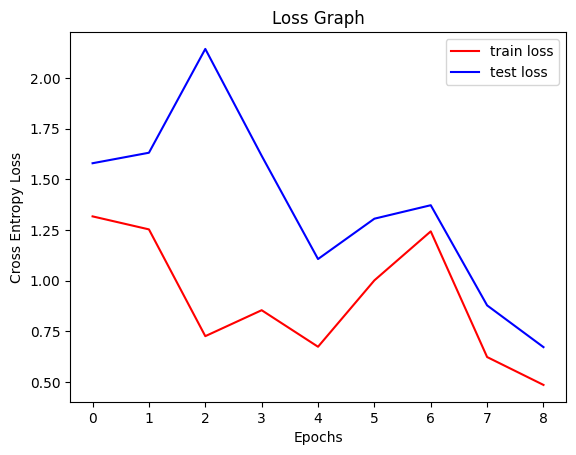

In [84]:
plt.plot(train_losses,'r',label='train loss')
plt.plot(test_losses,'b',label='test loss')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.legend()
plt.show();

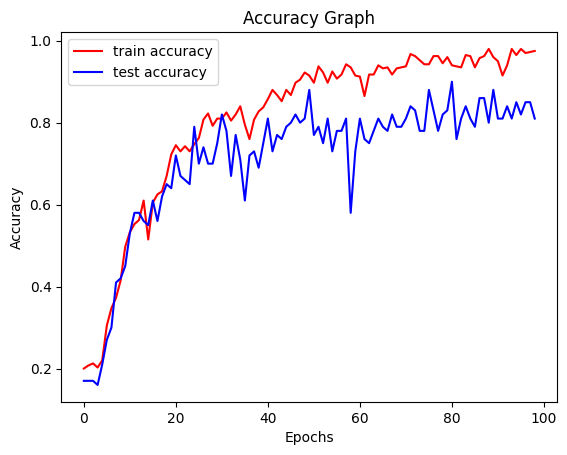

In [85]:
plt.plot(train_accuracies,'r',label='train accuracy')
plt.plot(test_accuracies,'b',label='test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show();

In [86]:
torch.save(densenet,'grapevine_leaves_image_densenet169_classifier.pt')

### MobileNet v3 large

In [91]:
mobilenet = models.mobilenet_v3_large(pretrained=True)
mobilenet

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 135MB/s] 


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [92]:
total_params = 0

for param in mobilenet.parameters():
    param.requires_grad = False
    print(param.numel())
    total_params += param.numel()

print("Total MobileNetv3 model parameters:", total_params)

432
16
16
144
16
16
256
16
16
1024
64
64
576
64
64
1536
24
24
1728
72
72
648
72
72
1728
24
24
1728
72
72
1800
72
72
1728
24
1728
72
2880
40
40
4800
120
120
3000
120
120
3840
32
3840
120
4800
40
40
4800
120
120
3000
120
120
3840
32
3840
120
4800
40
40
9600
240
240
2160
240
240
19200
80
80
16000
200
200
1800
200
200
16000
80
80
14720
184
184
1656
184
184
14720
80
80
14720
184
184
1656
184
184
14720
80
80
38400
480
480
4320
480
480
57600
120
57600
480
53760
112
112
75264
672
672
6048
672
672
112896
168
112896
672
75264
112
112
75264
672
672
16800
672
672
112896
168
112896
672
107520
160
160
153600
960
960
24000
960
960
230400
240
230400
960
153600
160
160
153600
960
960
24000
960
960
230400
240
230400
960
153600
160
160
153600
960
960
1228800
1280
1280000
1000
Total MobileNetv3 model parameters: 5483032


In [98]:
mobilenet.classifier = nn.Sequential(
    nn.Linear(960,1024),
    nn.ReLU(inplace=True),
    nn.Linear(1024,5),
    nn.LogSoftmax(dim=1)
)
mobilenet = mobilenet.cuda()
mobilenet

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [99]:
summary(mobilenet,input_shape=(1,3,128,128))

Layer (type:depth-idx)                             Param #
MobileNetV3                                        --
├─Sequential: 1-1                                  --
│    └─Conv2dNormActivation: 2-1                   --
│    │    └─Conv2d: 3-1                            (432)
│    │    └─BatchNorm2d: 3-2                       (32)
│    │    └─Hardswish: 3-3                         --
│    └─InvertedResidual: 2-2                       --
│    │    └─Sequential: 3-4                        (464)
│    └─InvertedResidual: 2-3                       --
│    │    └─Sequential: 3-5                        (3,440)
│    └─InvertedResidual: 2-4                       --
│    │    └─Sequential: 3-6                        (4,440)
│    └─InvertedResidual: 2-5                       --
│    │    └─Sequential: 3-7                        (10,328)
│    └─InvertedResidual: 2-6                       --
│    │    └─Sequential: 3-8                        (20,992)
│    └─InvertedResidual: 2-7                   

In [100]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(params=mobilenet.parameters(),lr=0.001)

In [101]:
epochs = 10

train_losses = []
test_losses = []
train_correct_predictions = []
test_correct_predictions = []

start_time = time.time()

for i in range(1,epochs):
    train_correct = 0
    test_correct = 0

    for batch_no, (X_train, y_train) in enumerate(train_data_loader):
        batch_no += 1
        X_train, y_train = X_train.cuda(), y_train.cuda()
        y_pred = mobilenet(X_train)  
        loss = criterion(y_pred,y_train)
        predicted = torch.max(y_pred,1)[1]
        train_correct += (predicted == y_train).sum()

        optimizer.zero_grad() # Reset model gradients to zero
        loss.backward() # Perform backpropagation
        optimizer.step() # Updates model weights and biases

        print(f"Epoch: {i} Batch: {batch_no} --> Loss: {loss.item()}")

    train_losses.append(loss.item())
    train_correct_predictions.append(train_correct.item())

    with torch.no_grad():
        for batch_no, (X_test, y_test) in enumerate(test_data_loader):
            X_test, y_test = X_test.cuda(), y_test.cuda()
            y_pred = mobilenet(X_test)
            predicted = torch.max(y_pred,1)[1]
            test_correct += (predicted == y_test).sum()

    loss = criterion(y_pred,y_test)
    test_losses.append(loss.item())
    test_correct_predictions.append(test_correct.item())

print(f"Total time elapsed in MobileNet v3 large model training: {(time.time()-start_time)/60} minutes")

Epoch: 1 Batch: 1 --> Loss: 1.6133205890655518
Epoch: 1 Batch: 2 --> Loss: 1.8147891759872437
Epoch: 1 Batch: 3 --> Loss: 1.6207866668701172
Epoch: 1 Batch: 4 --> Loss: 1.6034997701644897
Epoch: 1 Batch: 5 --> Loss: 1.389878749847412
Epoch: 1 Batch: 6 --> Loss: 1.1801570653915405
Epoch: 1 Batch: 7 --> Loss: 1.5419033765792847
Epoch: 1 Batch: 8 --> Loss: 1.3880130052566528
Epoch: 1 Batch: 9 --> Loss: 1.038411021232605
Epoch: 1 Batch: 10 --> Loss: 1.0712883472442627
Epoch: 1 Batch: 11 --> Loss: 0.9872686862945557
Epoch: 1 Batch: 12 --> Loss: 1.0163660049438477
Epoch: 1 Batch: 13 --> Loss: 1.2268235683441162
Epoch: 2 Batch: 1 --> Loss: 1.2186543941497803
Epoch: 2 Batch: 2 --> Loss: 1.1762399673461914
Epoch: 2 Batch: 3 --> Loss: 0.9739319086074829
Epoch: 2 Batch: 4 --> Loss: 0.8658469915390015
Epoch: 2 Batch: 5 --> Loss: 1.0308207273483276
Epoch: 2 Batch: 6 --> Loss: 0.9682934284210205
Epoch: 2 Batch: 7 --> Loss: 1.007431149482727
Epoch: 2 Batch: 8 --> Loss: 0.7348471283912659
Epoch: 2 Bat

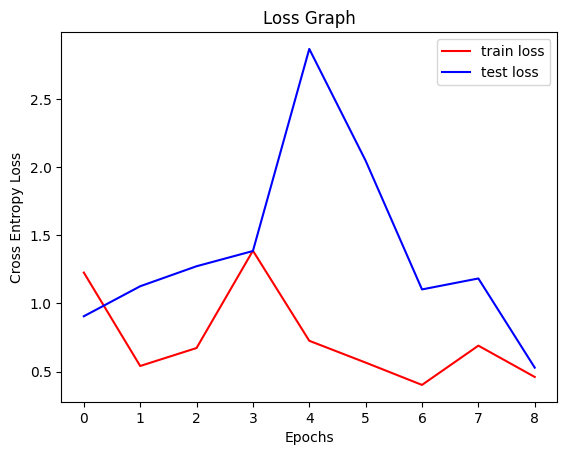

In [102]:
plt.plot(train_losses,'r',label='train loss')
plt.plot(test_losses,'b',label='test loss')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.legend()
plt.show();

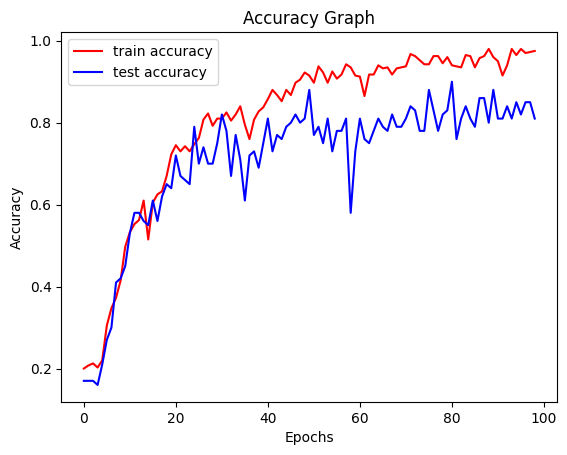

In [103]:
plt.plot(train_accuracies,'r',label='train accuracy')
plt.plot(test_accuracies,'b',label='test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show();

In [104]:
torch.save(mobilenet,'grapevine_leaves_image_mobilenet_classifier.pt')

## Comparing model performances

In [269]:
def evaluate_model_performance(model):
    correct_predictions = 0
    
    model.eval()
    
    with torch.no_grad():
        for batch_no, (X_test, y_test) in enumerate(test_data_loader):
            X_test, y_test = X_test.cuda(), y_test.cuda()
            y_pred = model(X_test)
            loss = criterion(y_pred,y_test)
            predicted = torch.max(y_pred,1)[1]
            correct_predictions += (predicted == y_test).sum().item()
    
    loss, acc =  loss.item(), round(correct_predictions/len(test_data_loader.dataset)*100,2)
    print(str(model).split('(')[0])
    print("Test loss:", loss)
    print("Test accuracy:", acc)

In [270]:
evaluate_model_performance(model)

CNN
Test loss: 0.5453383326530457
Test accuracy: 83.0


In [271]:
evaluate_model_performance(alexnet)

AlexNet
Test loss: 1.0074384212493896
Test accuracy: 56.0


In [272]:
evaluate_model_performance(resnet)

ResNet
Test loss: 9.945306777954102
Test accuracy: 17.0


In [273]:
evaluate_model_performance(densenet)

DenseNet
Test loss: 1.547560214996338
Test accuracy: 37.0


In [274]:
evaluate_model_performance(vgg19)

VGG
Test loss: 1.4584146738052368
Test accuracy: 56.0


In [275]:
evaluate_model_performance(mobilenet)

MobileNetV3
Test loss: 2.092101573944092
Test accuracy: 59.0


So, the baseline CNN model produced the best performance with a stupendous accuracy of about 83% on the test dataset as compared to pretrained image classification models such as AlexNet, ResNet50, VGG19, etc. The results are not surprising at all as these pretrained models have been trained on image data, which is completely irrelevant to our use case, that is, to classify the grapevine leaves. These models might not have learned the necessary features pertaining to grapevine leaves.